# 1. Загрузка данных и первичный анализ

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.inspection import permutation_importance
import joblib
import json
import os

# Загрузка данных (уже загружены, но для воспроизводимости)

In [12]:
df = pd.read_csv('S06-hw-dataset-01.csv')  # Предполагаем, что файл в той же директории
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о датасете:")
print(df.info())
print("\nБазовые статистики:")
print(df.describe())
print("\nРаспределение целевой переменной:")
# print(df['target'].value_counts(normalize=True))
target_counts = df['target'].value_counts()
print(f"Класс 0: {target_counts.get(0, 0)} записей ({target_counts.get(0, 0)/len(df)*100:.1f}%)")
print(f"Класс 1: {target_counts.get(1, 0)} записей ({target_counts.get(1, 0)/len(df)*100:.1f}%)")
print("\nПропуски:")
print(df.isnull().sum())

Размер датасета: (12000, 30)

Первые 5 строк:
   id     num01     num02     num03     num04     num05     num06     num07  \
0   1 -0.946058 -0.070313  1.824445 -2.754422  0.808865 -0.111094 -0.268950   
1   2 -2.484027  0.739378  1.596908 -2.586479 -0.033225 -3.054412 -4.706908   
2   3  1.522629  7.159635 -0.564903 -4.493110  1.623610  5.450187 -0.974595   
3   4  0.463373 -1.073908  1.752813  0.362786  2.790872  4.082385  0.322283   
4   5  3.188390 -4.701692 -0.689918 -0.448995  0.373821 -3.275363 -1.760931   

      num08     num09  ...     num20     num21     num22     num23     num24  \
0 -3.078210  0.801275  ... -1.616515 -1.989464  1.407390 -0.218362  2.016052   
1 -9.795169  0.145911  ... -1.727040 -0.583997  1.136761  0.285978 -0.310879   
2 -5.189589  1.600591  ...  0.524408  2.022430  1.278358 -0.850547  0.847457   
3  3.390984 -0.033929  ...  2.399834 -1.431576 -0.746987  0.049639  2.414689   
4  0.923689  0.537345  ... -2.183407 -2.896590  2.440343 -1.097168  1.457323   

# 2. Подготовка признаков и таргета

In [7]:
X = df.drop(columns=['id', 'target'])
y = df['target']

# Преобразуем категориальные признаки в тип 'category' (если нужно)
cat_cols = ['cat_contract', 'cat_region', 'cat_payment']
for col in cat_cols:
    X[col] = X[col].astype('category')

# 3. Train/Test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTrain size: {X_train.shape}, Test size: {X_test.shape}")
print("Распределение классов в train:", y_train.value_counts(normalize=True))
print("Распределение классов в test:", y_test.value_counts(normalize=True))


Train size: (9600, 28), Test size: (2400, 28)
Распределение классов в train: target
0    0.676562
1    0.323437
Name: proportion, dtype: float64
Распределение классов в test: target
0    0.676667
1    0.323333
Name: proportion, dtype: float64


# 4. Baseline модели

In [9]:
# 4.1 DummyClassifier
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1] if hasattr(dummy, 'predict_proba') else None

metrics = {}
metrics['Dummy'] = {
    'accuracy': accuracy_score(y_test, y_pred_dummy),
    'f1': f1_score(y_test, y_pred_dummy),
    'roc_auc': roc_auc_score(y_test, y_proba_dummy) if y_proba_dummy is not None else None
}

# 4.2 LogisticRegression с пайплайном (StandardScaler)
# One-hot encoding для категориальных признаков
X_train_encoded = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)
# Убедимся, что колонки совпадают
missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
for col in missing_cols:
    X_test_encoded[col] = 0
X_test_encoded = X_test_encoded[X_train_encoded.columns]

logreg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])
logreg_pipe.fit(X_train_encoded, y_train)
y_pred_logreg = logreg_pipe.predict(X_test_encoded)
y_proba_logreg = logreg_pipe.predict_proba(X_test_encoded)[:, 1]

metrics['LogisticRegression'] = {
    'accuracy': accuracy_score(y_test, y_pred_logreg),
    'f1': f1_score(y_test, y_pred_logreg),
    'roc_auc': roc_auc_score(y_test, y_proba_logreg)
}

print("\nМетрики baseline моделей:")
for model, metric in metrics.items():
    print(f"{model}: {metric}")


Метрики baseline моделей:
Dummy: {'accuracy': 0.6766666666666666, 'f1': 0.0, 'roc_auc': 0.5}
LogisticRegression: {'accuracy': 0.8270833333333333, 'f1': 0.7071277346506705, 'roc_auc': 0.8752285308008735}


# 5. Модели недели 6

 Боксплот для количественного признака (выручка по странам)

In [13]:
# 5.1 DecisionTreeClassifier с подбором гиперпараметров
tree = DecisionTreeClassifier(random_state=42)
param_grid_tree = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}
grid_tree = GridSearchCV(tree, param_grid_tree, cv=5, scoring='roc_auc', n_jobs=-1)
grid_tree.fit(X_train_encoded, y_train)
print(f"\nЛучшие параметры для DecisionTree: {grid_tree.best_params_}")
print(f"Лучший ROC-AUC на кросс-валидации: {grid_tree.best_score_:.4f}")

# 5.2 RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2']
}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train_encoded, y_train)
print(f"\nЛучшие параметры для RandomForest: {grid_rf.best_params_}")
print(f"Лучший ROC-AUC на кросс-валидации: {grid_rf.best_score_:.4f}")

# 5.3 Boosting (GradientBoostingClassifier)
gb = GradientBoostingClassifier(random_state=42)
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_gb.fit(X_train_encoded, y_train)
print(f"\nЛучшие параметры для GradientBoosting: {grid_gb.best_params_}")
print(f"Лучший ROC-AUC на кросс-валидации: {grid_gb.best_score_:.4f}")



Лучшие параметры для DecisionTree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10}
Лучший ROC-AUC на кросс-валидации: 0.9086

Лучшие параметры для RandomForest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}
Лучший ROC-AUC на кросс-валидации: 0.9690

Лучшие параметры для GradientBoosting: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Лучший ROC-AUC на кросс-валидации: 0.9734


# 6. Оценка на тестовом наборе

In [14]:
models = {
    'DecisionTree': grid_tree.best_estimator_,
    'RandomForest': grid_rf.best_estimator_,
    'GradientBoosting': grid_gb.best_estimator_
}

for name, model in models.items():
    y_pred = model.predict(X_test_encoded)
    y_proba = model.predict_proba(X_test_encoded)[:, 1]
    metrics[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    }

print("\nМетрики всех моделей на тестовом наборе:")
for model, metric in metrics.items():
    print(f"{model}: {metric}")


Метрики всех моделей на тестовом наборе:
Dummy: {'accuracy': 0.6766666666666666, 'f1': 0.0, 'roc_auc': 0.5}
LogisticRegression: {'accuracy': 0.8270833333333333, 'f1': 0.7071277346506705, 'roc_auc': 0.8752285308008735}
DecisionTree: {'accuracy': 0.87625, 'f1': 0.799459824442944, 'roc_auc': 0.9080437287339393}
RandomForest: {'accuracy': 0.92625, 'f1': 0.879837067209776, 'roc_auc': 0.9665115090650551}
GradientBoosting: {'accuracy': 0.9345833333333333, 'f1': 0.8959575878064944, 'roc_auc': 0.9708893022192878}


# 7. Определение лучшей модели по ROC-AUC


In [15]:
best_model_name = max(metrics, key=lambda x: metrics[x]['roc_auc'] if metrics[x]['roc_auc'] is not None else 0)
best_model = models[best_model_name] if best_model_name in models else None
if best_model_name == 'LogisticRegression':
    best_model = logreg_pipe
elif best_model_name == 'Dummy':
    best_model = dummy

print(f"\nЛучшая модель: {best_model_name} с ROC-AUC = {metrics[best_model_name]['roc_auc']:.4f}")



Лучшая модель: GradientBoosting с ROC-AUC = 0.9709


# 8. Интерпретация лучшей модели (permutation importance)



Top-15 признаков по permutation importance:
   feature  importance_mean  importance_std
18   num19         0.104708        0.005719
17   num18         0.100875        0.004604
6    num07         0.060750        0.003280
3    num04         0.027083        0.002934
23   num24         0.022792        0.003555
0    num01         0.016208        0.003115
19   num20         0.015667        0.002630
13   num14         0.015125        0.002820
15   num16         0.010542        0.000933
21   num22         0.009292        0.002408
20   num21         0.009250        0.001190
7    num08         0.007792        0.001223
1    num02         0.005917        0.001716
16   num17         0.005292        0.002042
12   num13         0.003500        0.001384


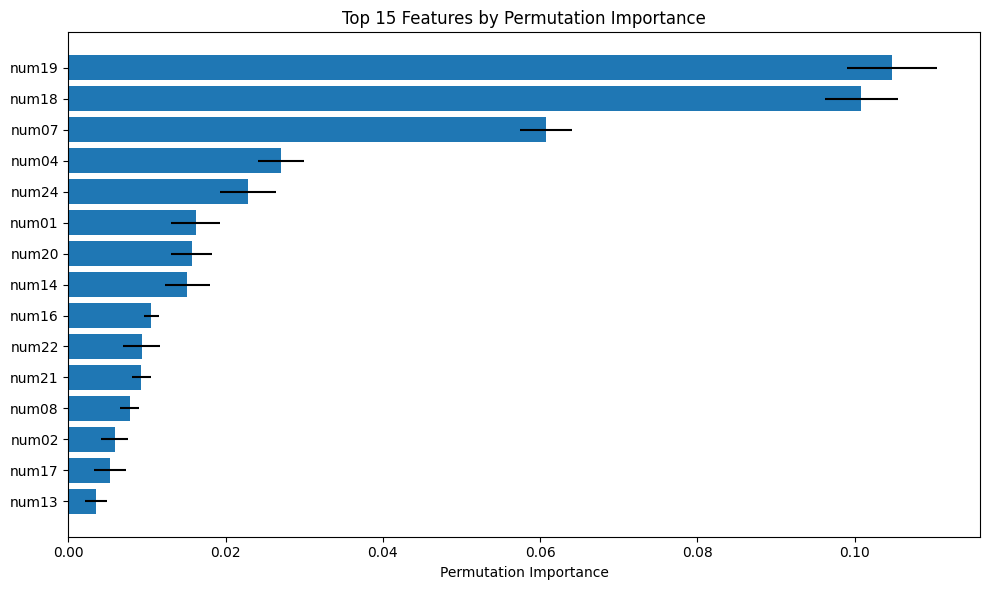

In [19]:
if best_model is not None:
    result = permutation_importance(best_model, X_test_encoded, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    importance_df = pd.DataFrame({
        'feature': X_test_encoded.columns,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std
    })
    importance_df = importance_df.sort_values('importance_mean', ascending=False).head(15)
    print("\nTop-15 признаков по permutation importance:")
    print(importance_df)

    # Визуализация
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'], importance_df['importance_mean'], xerr=importance_df['importance_std'])
    plt.xlabel('Permutation Importance')
    plt.title('Top 15 Features by Permutation Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('artifacts/figures/permutation_importance.png')
    plt.show()

# 9. ROC-кривая для лучшей модели

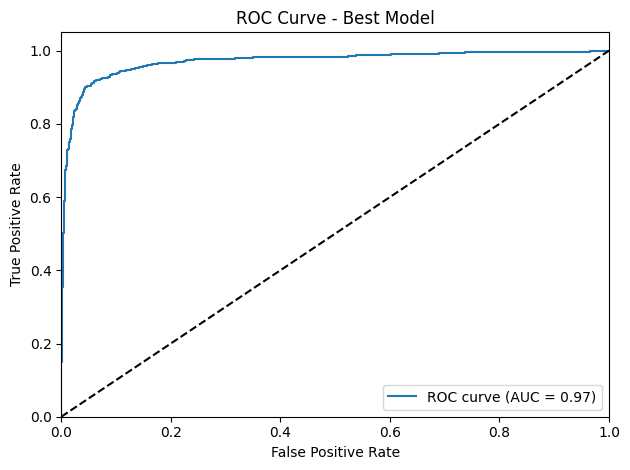

In [22]:
if best_model is not None:
    y_proba_best = best_model.predict_proba(X_test_encoded)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba_best)
    roc_auc = roc_auc_score(y_test, y_proba_best)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Best Model')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig('artifacts/figures/roc_curve.png')
    plt.show()

# 10. Confusion matrix для лучшей модели



Confusion matrix для лучшей модели


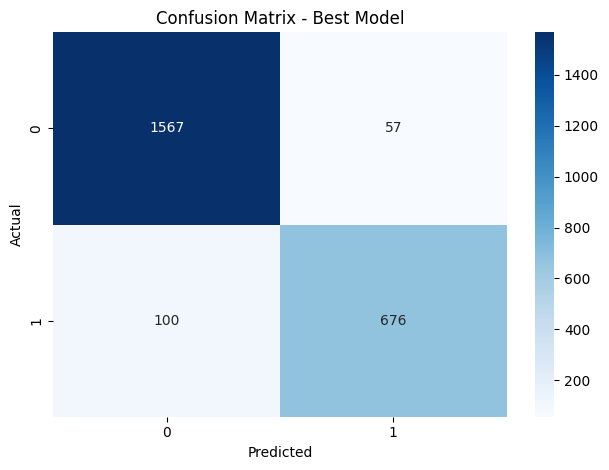


Сохранение артефактов

Артефакты сохранены в папке 'artifacts/':
  ✓ artifacts/figures/confusion_matrix.png
  ✓ artifacts/metrics_test.json
  ✓ artifacts/search_summaries.json
  ✓ artifacts/best_model.joblib
  ✓ artifacts/best_model_meta.json


In [24]:
# 10. Confusion matrix для лучшей модели 
print("\n" + "="*50)
print("Confusion matrix для лучшей модели")
print("="*50)

if best_model is not None:
    y_pred_best = best_model.predict(X_test_encoded)
    cm = confusion_matrix(y_test, y_pred_best)

    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Best Model')
    plt.tight_layout()
    plt.savefig('artifacts/figures/confusion_matrix.png')
    plt.show()

# 11. Сохранение артефактов
print("\n" + "="*50)
print("Сохранение артефактов")
print("="*50)

import json
import joblib

# 11.1 Сохраняем метрики
with open('artifacts/metrics_test.json', 'w') as f:
    json.dump(metrics, f, indent=4)

# 11.2 Сохраняем информацию о подборе гиперпараметров
search_summaries = {
    'DecisionTree': {
        'best_params': grid_tree.best_params_,
        'best_score': float(grid_tree.best_score_)
    },
    'RandomForest': {
        'best_params': grid_rf.best_params_,
        'best_score': float(grid_rf.best_score_)
    },
    'GradientBoosting': {
        'best_params': grid_gb.best_params_,
        'best_score': float(grid_gb.best_score_)
    }
}
with open('artifacts/search_summaries.json', 'w') as f:
    json.dump(search_summaries, f, indent=4)

# 11.3 Сохраняем лучшую модель
if best_model is not None:
    joblib.dump(best_model, 'artifacts/best_model.joblib')

# 11.4 Сохраняем метаданные лучшей модели
best_model_meta = {
    'best_model_name': best_model_name,
    'best_model_params': best_model.get_params() if hasattr(best_model, 'get_params') else None,
    'test_metrics': metrics[best_model_name]
}
with open('artifacts/best_model_meta.json', 'w') as f:
    json.dump(best_model_meta, f, indent=4)

print("\nАртефакты сохранены в папке 'artifacts/':")
print("  ✓ artifacts/figures/confusion_matrix.png")
print("  ✓ artifacts/metrics_test.json")
print("  ✓ artifacts/search_summaries.json")
print("  ✓ artifacts/best_model.joblib")
print("  ✓ artifacts/best_model_meta.json")